In [1]:
%load_ext autoreload
%autoreload 2

from collections import OrderedDict

from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from respy_smm.MaximumLikelihoodEstimation import MaximumLikelihoodEstimationCls
from respy_smm.SimulationBasedEstimation import SimulationBasedEstimationCls
from respy_smm.optimizers.auxiliary_pybobyqa import wrapper_pybobyqa
from respy_smm.auxiliary_depreciation import respy_obj_from_new_init
from respy_smm.optimizers.auxiliary_pybobyqa import get_box_bounds
from respy.pre_processing.data_processing import process_dataset

def plot_criterion_function(rslt):
    fig, ax = plt.subplots(1, 1)
    ax.plot(rslt["fval"])
    ax.set_title('Criterion function during optimization')
    ax.set_ylabel('Criterion function')
    ax.set_xlabel('Evaluation')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

In [2]:
respy_obj = respy_obj_from_new_init('truth.respy.ini')

respy_obj.simulate()
df = process_dataset(respy_obj)

## Maximum likelihood estimation

We establish the baseline.

In [3]:
mle_truth = MaximumLikelihoodEstimationCls(*('truth.respy.ini', 200)).fval['start']
print(' ... value of MLE criterion function at truth {:10.5f}'.format(mle_truth))

 ... value of MLE criterion function at truth    5.33540


Now we are ready to start the estimation.

In [4]:
init_file, max_evals = 'model.respy.ini', 20

mle_obj = MaximumLikelihoodEstimationCls(*(init_file, max_evals))
box = get_box_bounds(init_file)

kwargs = dict()
kwargs['scaling_within_bounds'] = True
kwargs['bounds'] = (box[:, 0], box[:, 1])
kwargs['objfun_has_noise'] = True
kwargs['maxfun'] = 10e6

rslt = wrapper_pybobyqa(mle_obj.evaluate, mle_obj.x_free_econ_start, **kwargs)

We are not ready to inspect the quality of our optimization.

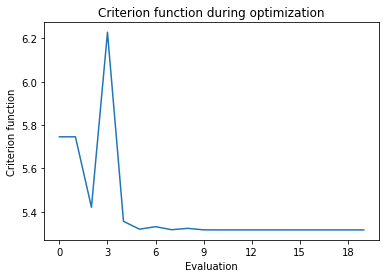

In [5]:
plot_criterion_function(rslt)

## Simulated method of moments

In [6]:
def get_moments(df):
    
    moments = OrderedDict()
    moments['Choice Probability'] = OrderedDict()
    info = df['Choice'].groupby('Period').value_counts(normalize=True).to_dict()
    for period in sorted(df['Period'].unique().tolist()):
        moments['Choice Probability'][period] = []
        for choice in range(1, 5):
            try:
                stat = info[(period, choice)]
            except KeyError:
                stat = 0.00
            moments['Choice Probability'][period].append(stat)
    return moments

weighing_matrix = np.identity(4 * 5)
moments_obs = get_moments(df)

We establish a baseline.

In [7]:
args = ('truth.respy.ini', moments_obs, weighing_matrix, get_moments, max_evals)
smm_truth = SimulationBasedEstimationCls(*args).fval['start']
print(' ... value of SMM criterion function at truth {:10.5f}'.format(smm_truth))

 ... value of SMM criterion function at truth    0.00753


In [8]:
init_file, max_evals = 'model.respy.ini', 200

args = (init_file, moments_obs, weighing_matrix, get_moments, max_evals)
smm_obj = SimulationBasedEstimationCls(*args)

kwargs = dict()
kwargs['scaling_within_bounds'] = True
kwargs['bounds'] = (box[:, 0], box[:, 1])
kwargs['objfun_has_noise'] = True
kwargs['maxfun'] = 10e6

rslt = wrapper_pybobyqa(smm_obj.evaluate, smm_obj.x_free_econ_start, **kwargs)

We can now look at the progress of the optimization over time.

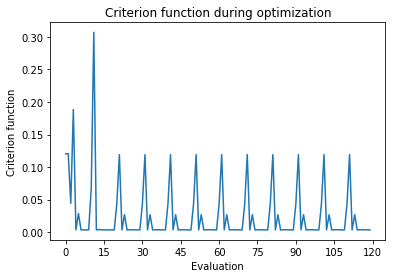

In [9]:
plot_criterion_function(rslt)